## Comparing HITEMP and ExoMol

In [1]:
from exojax.spec import xsection
from exojax.spec.hitran import SijT, doppler_sigma, gamma_hitran, gamma_natural
from exojax.spec.exomol import gamma_exomol
from exojax.spec import api 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('bmh')

HAPI version: 1.2.2.0
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2021 are now available in HAPI code

           MIT license: Copyright 2021 HITRAN team, see more at http://hitran.org. 

           If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005

           ATTENTION: This is the core version of the HITRAN Application Programming Interface.
                      For more efficient implementation of the absorption coefficient routine, 
                      as well as for new profiles, parameters and other functional,
      

First of all, set a wavenumber bin in the unit of wavenumber (cm-1).
Here we set the wavenumber range as $1000 \le \nu \le 10000$ (1/cm) with the resolution of 0.01 (1/cm). 

We call moldb instance with the path of par file.
If the par file does not exist, moldb will try to download it from HITRAN website.

In [2]:
# Setting wavenumber bins and loading HITEMP database
wav=np.linspace(22930.0,23000.0,4000,dtype=np.float64) #AA
nus=1.e8/wav[::-1] #cm-1

In [12]:
mdbCO_HITEMP=api.MdbHitemp('05_HITEMP2019.par.bz2',nus)

Download complete. Parsing CO database to /home/kawahara/exojax/documents/tutorials/CO-05_HITEMP2019.hdf5
Added HITEMP-{molecule} database in /home/kawahara/radis.json


In [6]:
emf='CO/12C-16O/Li2015'
mdbCO_Li2015=api.MdbExomol(emf,nus)

Background atmosphere:  H2
Error: Couldn't download .broad file at http://www.exomol.com/db/CO/12C-16O/12C-16O__air.broad and save.
Note: Caching states data to the vaex format. After the second time, it will become much faster.
Reading CO/12C-16O/Li2015/12C-16O__Li2015.trans.bz2
Note: Caching line transition data to the vaex format. After the second time, it will become much faster.
.broad is used.
Broadening code level= a0
default broadening parameters are used for  71  J lower states in  152  states


Define molecular weight of CO ($\sim 12+16=28$), temperature (K), and pressure (bar).
Also, we here assume the 100 % CO atmosphere, i.e. the partial pressure = pressure.  

In [7]:
from exojax.spec import molinfo
Mmol=molinfo.molmass("CO") # molecular weight
Tfix=1300.0 # we assume T=1300K
Pfix=0.99 # we compute P=1 bar=0.99+0.1
Ppart=0.01 #partial pressure of CO. here we assume a 1% CO atmosphere (very few). 

partition function ratio $q(T)$ is defined by 

$q(T) = Q(T)/Q(T_{ref})$; $T_{ref}$=296 K

Here, we use the partition function from HAPI

In [16]:
#mdbCO_HITEMP.ExomolQT(emf) #use Q(T) from Exomol/Li2015
qt_HITEMP=mdbCO_HITEMP.qr_interp(0,Tfix)
qt_Li2015=mdbCO_Li2015.qr_interp(Tfix)

Let us compute the line strength S(T) at temperature of Tfix.

$S (T;s_0,\nu_0,E_l,q(T)) = S_0 \frac{Q(T_{ref})}{Q(T)} \frac{e^{- h c E_l /k_B T}}{e^{- h c E_l /k_B T_{ref}}} \frac{1- e^{- h c \nu /k_B T}}{1-e^{- h c \nu /k_B T_{ref}}}= q_r(T)^{-1} e^{ s_0 - c_2 E_l (T^{-1} - T_{ref}^{-1})}  \frac{1- e^{- c_2 \nu_0/ T}}{1-e^{- c_2 \nu_0/T_{ref}}}$

$s_0=\log_{e} S_0$ : logsij0

$\nu_0$: nu_lines

$E_l$ : elower

Why the input is $s_0 = \log_{e} S_0$ instead of $S_0$ in SijT? This is because the direct value of $S_0$ is quite small and we need to use float32 for jax.  

We need to call 'generate_jnp_arrays' to compute $logsij0$.

In [19]:
mdbCO_HITEMP.generate_jnp_arrays()
mdbCO_Li2015.generate_jnp_arrays()

/home/kawahara/anaconda3/lib/python3.8/site-packages/exojax-1.1.3-py3.8.egg/exojax/spec/api.py:370: RuntimeWarning: divide by zero encountered in log
  self.logsij0 = jnp.array(np.log(self.Sij0))


In [20]:
Sij_HITEMP=SijT(Tfix,mdbCO_HITEMP.logsij0,mdbCO_HITEMP.nu_lines,\
         mdbCO_HITEMP.elower,qt_HITEMP)
Sij_Li2015=SijT(Tfix,mdbCO_Li2015.logsij0,mdbCO_Li2015.nu_lines,\
                mdbCO_Li2015.elower,qt_Li2015)

Then, compute the Lorentz gamma factor (pressure+natural broadening)

$\gamma_L = \gamma^p_L + \gamma^n_L$

where the pressure broadning (HITEMP)

$\gamma^p_L = (T/296K)^{-n_{air}} [ \alpha_{air} ( P - P_{part})/P_{atm} + \alpha_{self} P_{part}/P_{atm}]$

$P_{atm}$: 1 atm in the unit of bar (i.e. = 1.01325)

or 

the pressure broadning (ExoMol)

$\gamma^p_L = \alpha_{ref}  ( T/T_{ref} )^{-n_{texp}} ( P/P_{ref}), $


and the natural broadening

$\gamma^n_L = \frac{A}{4 \pi c}$

In [21]:
gammaL_HITEMP = gamma_hitran(Pfix,Tfix, Ppart, mdbCO_HITEMP.n_air, \
                      mdbCO_HITEMP.gamma_air, mdbCO_HITEMP.gamma_self) \
+ gamma_natural(mdbCO_HITEMP.A) 

gammaL_Li2015 = gamma_exomol(Pfix,Tfix,mdbCO_Li2015.n_Texp,mdbCO_Li2015.alpha_ref)\
+ gamma_natural(mdbCO_Li2015.A) 

Thermal broadening

$\sigma_D^{t} = \sqrt{\frac{k_B T}{M m_u}} \frac{\nu_0}{c}$

In [22]:
# thermal doppler sigma
sigmaD_HITEMP=doppler_sigma(mdbCO_HITEMP.nu_lines,Tfix,Mmol)
sigmaD_Li2015=doppler_sigma(mdbCO_Li2015.nu_lines,Tfix,Mmol)

Then, the line center...

In HITRAN database, a slight pressure shift can be included using $\delta_{air}$:
$\nu_0(P) = \nu_0 + \delta_{air} P$. But this shift is quite a bit. 

In [23]:
#line center
nu0_HITEMP=mdbCO_HITEMP.nu_lines
nu0_Li2015=mdbCO_Li2015.nu_lines

Although it depends on your GPU, you might need to devide the computation into multiple loops because of the limitation of the GPU memory. Here we assume 30MB for GPU memory (not exactly, memory size for numatrix). 

In [24]:
xsv_HITEMP=xsection(nus,nu0_HITEMP,sigmaD_HITEMP,gammaL_HITEMP\
                     ,Sij_HITEMP,memory_size=30) #use 30MB GPU MEMORY for numax
xsv_Li2015=xsection(nus,nu0_Li2015,sigmaD_Li2015,gammaL_Li2015\
                     ,Sij_Li2015,memory_size=30) #use 30MB GPU MEMORY for numax

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


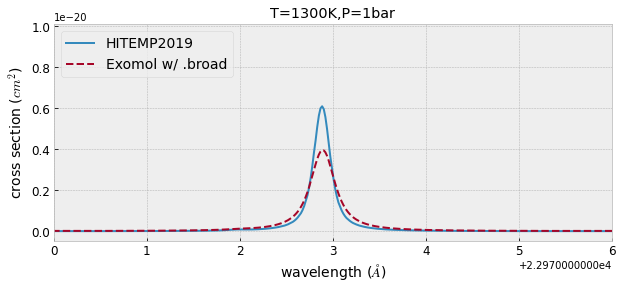

In [25]:
fig=plt.figure(figsize=(10,4))
ax=fig.add_subplot(111)
plt.plot(wav[::-1],xsv_HITEMP,lw=2,label="HITEMP2019")
plt.plot(wav[::-1],xsv_Li2015,lw=2,ls="dashed",label="Exomol w/ .broad")
plt.xlim(22970,22976)
plt.xlabel("wavelength ($\AA$)",fontsize=14)
plt.ylabel("cross section ($cm^{2}$)",fontsize=14)
plt.legend(loc="upper left",fontsize=14)
plt.tick_params(labelsize=12)
plt.savefig("co_comparison.pdf", bbox_inches="tight", pad_inches=0.0)
plt.savefig("co_comparison.png", bbox_inches="tight", pad_inches=0.0)
plt.title("T=1300K,P=1bar")
plt.show()